In [1]:
# initiating gpu using tensorflow.
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)


2022-10-22 09:08:08.101279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 09:08:08.269068: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-22 09:08:09.215138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-22 09:08:09.215247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7



2022-10-22 09:08:11.672625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10221 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [1]:
from glob import glob
import numpy as np
from tifffile import imread
from PIL import Image
import PIL.ImageOps  
import pandas as pd
import os
import cv2
import csv
Image.MAX_IMAGE_PIXELS = None
from tqdm import tqdm
import random 
import os
from shutil import copy,copytree
import shutil
import fnmatch
#!pip install patchify
#from patchify import patchify
import os
#visulaziation
import matplotlib.pyplot as plt
from pathlib import Path
Image.MAX_IMAGE_PIXELS = 933120000
import sys

#from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet101V2, Xception, ResNet50V2, VGG19
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

#setting seed to reproduce the same result every time the code is re-run


# Analysis

In [2]:
target_size=(512,512)
target_shape=[512,512]
protein_name= 'SDHA'
random_state=99
dataset_name='AllPatients' 
model_name='ResNet50V2'
model_name_PH='ResNet50'
nDNA_PH= ''
version='v4'

In [3]:

tf.random.set_seed(random_state)
np.random.seed(random_state)

In [4]:
image_dir = Path(f'./Dataset_TIFF_{protein_name}/{nDNA_PH}split_512')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.tiff'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
 # Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,Dataset_TIFF_SDHA/split_512/controls/C04_SDHA0...,controls
1,Dataset_TIFF_SDHA/split_512/patients/P10_SDHA0...,patients
2,Dataset_TIFF_SDHA/split_512/patients/P04_SDHA0...,patients
3,Dataset_TIFF_SDHA/split_512/patients/P03_SDHA0...,patients
4,Dataset_TIFF_SDHA/split_512/controls/C04_SDHA0...,controls


In [6]:
# Separate in train and test data
train_df1, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=random_state)

In [7]:
# Separate in train and test data
train_df, val_df = train_test_split(train_df1, train_size=0.9, shuffle=True, random_state=random_state)

In [8]:
train_datagen=ImageDataGenerator(rescale = 1./225,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
val_datagen=ImageDataGenerator(rescale = 1./225)
test_datagen=ImageDataGenerator(rescale = 1./225)

In [9]:
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=True,
    seed=random_state,
    subset='training'
)
val_images = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=False
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=False
)

Found 220 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.


In [11]:
def create_model():
    # Load the pretained model
    pretrained_model = tf.keras.applications.ResNet50V2(
        input_shape=(512,512, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input
    x = tf.keras.layers.Dense(2048, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model
    

In [12]:
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.001), 
        metrics=['accuracy'])

2022-10-22 09:08:13.013061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10221 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_out (Add)         (None, 128, 128, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_conv[0][0]']    
                                                                                                  
 conv2_block3_preact_bn (BatchN  (None, 128, 128, 25  1024       ['conv2_block2_out[0][0]']       
 ormalization)                  6)                                                                
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 128, 128, 25  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                        6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 128, 128, 64  16384       ['conv2_block3_preact_relu[0][0]'
          

 n)                                                                                               
                                                                                                  
 conv3_block2_2_pad (ZeroPaddin  (None, 66, 66, 128)  0          ['conv3_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 64, 64, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block1_preact_relu (Acti  (None, 32, 32, 512)  0          ['conv4_block1_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 32, 32, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 32, 32, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 32, 32, 256)  589824      ['conv4_block3_2_pad[0][0]']     
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 32, 32, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 32, 32, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 32, 32, 1024  263168      ['conv4_block3_2_relu[0][0]']    
          

 vation)                        )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 32, 32, 256)  262144      ['conv4_block6_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 32, 32, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 32, 32, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 16, 16, 512)  2359296     ['conv5_block2_2_pad[0][0]']     
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 16, 16, 512)  2048       ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 16, 16, 512)  0          ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 16, 16, 2048  1050624     ['conv5_block2_2_relu[0][0]']    
          

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=400,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=200,
            restore_best_weights=True
        )
    ]
)

Epoch 1/400


2022-10-22 09:08:19.882204: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-10-22 09:08:20.130317: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


40/40 [==============================] - 20s 327ms/step - loss: 1.5240 - accuracy: 0.6709 - val_loss: 1.4822 - val_accuracy: 0.4444
Epoch 2/400
40/40 [==============================] - 9s 231ms/step - loss: 0.5444 - accuracy: 0.8608 - val_loss: 0.7737 - val_accuracy: 0.8889
Epoch 3/400
40/40 [==============================] - 10s 236ms/step - loss: 0.3921 - accuracy: 0.8481 - val_loss: 0.3055 - val_accuracy: 0.8889
Epoch 4/400
40/40 [==============================] - 10s 240ms/step - loss: 0.4707 - accuracy: 0.9241 - val_loss: 1.0844 - val_accuracy: 0.8889
Epoch 5/400
40/40 [==============================] - 10s 235ms/step - loss: 0.1399 - accuracy: 0.9494 - val_loss: 0.5044 - val_accuracy: 0.8889
Epoch 6/400
40/40 [==============================] - 10s 245ms/step - loss: 0.1141 - accuracy: 0.9367 - val_loss: 0.0539 - val_accuracy: 1.0000
Epoch 7/400
40/40 [==============================] - 9s 227ms/step - loss: 0.0822 - accuracy: 0.9620 - val_loss: 0.2606 - val_accuracy: 0.8889
Epoch 

Epoch 58/400
40/40 [==============================] - 9s 220ms/step - loss: 0.0451 - accuracy: 0.9873 - val_loss: 0.2331 - val_accuracy: 0.8889
Epoch 59/400
40/40 [==============================] - 9s 228ms/step - loss: 0.0456 - accuracy: 0.9747 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 60/400
40/40 [==============================] - 9s 227ms/step - loss: 0.0359 - accuracy: 0.9873 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 61/400
40/40 [==============================] - 9s 230ms/step - loss: 0.0498 - accuracy: 0.9747 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 62/400
40/40 [==============================] - 9s 219ms/step - loss: 0.0387 - accuracy: 0.9873 - val_loss: 1.0331 - val_accuracy: 0.8889
Epoch 63/400
40/40 [==============================] - 9s 222ms/step - loss: 0.0346 - accuracy: 0.9873 - val_loss: 1.4752 - val_accuracy: 0.8889
Epoch 64/400
40/40 [==============================] - 9s 228ms/step - loss: 0.0994 - accuracy: 0.9873 - val_loss: 0.9522 - val_accuracy:

40/40 [==============================] - 9s 222ms/step - loss: 0.0442 - accuracy: 0.9873 - val_loss: 0.1026 - val_accuracy: 0.8889
Epoch 171/400
40/40 [==============================] - 9s 231ms/step - loss: 0.0343 - accuracy: 0.9873 - val_loss: 0.0810 - val_accuracy: 0.8889
Epoch 172/400
40/40 [==============================] - 9s 214ms/step - loss: 0.0716 - accuracy: 0.9873 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 173/400
40/40 [==============================] - 8s 208ms/step - loss: 0.1377 - accuracy: 0.9367 - val_loss: 0.1527 - val_accuracy: 0.8889
Epoch 174/400
40/40 [==============================] - 9s 219ms/step - loss: 0.0424 - accuracy: 0.9873 - val_loss: 0.0763 - val_accuracy: 1.0000
Epoch 175/400
40/40 [==============================] - 9s 214ms/step - loss: 0.0732 - accuracy: 0.9747 - val_loss: 0.0839 - val_accuracy: 0.8889
Epoch 176/400
40/40 [==============================] - 9s 215ms/step - loss: 0.0427 - accuracy: 0.9873 - val_loss: 0.0768 - val_accuracy: 1.0000

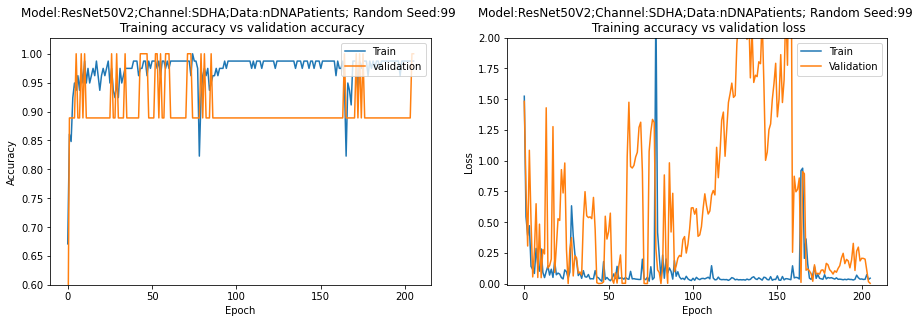

In [14]:
# Plot training & validation accuracy values
plt.figure(1, figsize = (15,10)) 
plt.subplot(221) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f"Model:{model_name};Channel:{protein_name};Data:{dataset_name}; Random Seed:{random_state} \n Training accuracy vs validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim((0.6))
plt.legend(['Train', 'validation'], loc='upper right')

# Plot training & validation loss values
plt.subplot(222) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"Model:{model_name};Channel:{protein_name};Data:{dataset_name}; Random Seed:{random_state} \n Training accuracy vs validation loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((-0.01,2))
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [15]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.80149
Test Accuracy: 80.00%


In [16]:
model.save(f'./models/{protein_name}/ResNet50_{dataset_name}_{protein_name}_512_Protein_{version}_{random_state}.h5')
print("saved the model")

saved the model


In [17]:
model_loaded = load_model(f'./models/{protein_name}/ResNet50_{dataset_name}_{protein_name}_512_Protein_{version}_{random_state}.h5')

# Classification Report

In [18]:
# Predict the label of the test_images
pred = model_loaded.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

5/5 [==============================] - 2s 86ms/step


In [19]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

     controls       0.86      0.86      0.86         7
nDNA_patients       0.67      0.67      0.67         3

     accuracy                           0.80        10
    macro avg       0.76      0.76      0.76        10
 weighted avg       0.80      0.80      0.80        10



In [20]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, pred)

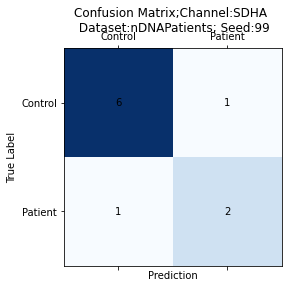

<Figure size 1080x720 with 0 Axes>

In [21]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Blues)

ax.set_title(f"Confusion Matrix;Channel:{protein_name} \n Dataset:{dataset_name}; Seed:{random_state}")
ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

tick_labels = ['Control', 'Patient']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.figure(figsize=(15,10))
plt.show()

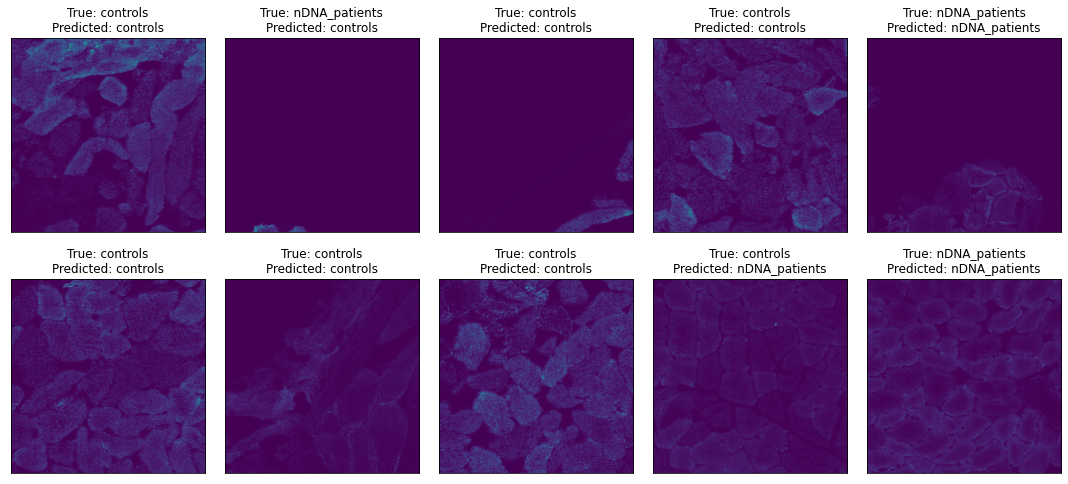

In [22]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()